## Masters of the Great Web and Cyberpunks. ERC721 Analysis

In [1]:
from config import PROJECT_ID, INITIAL_TS, SNAPSHOT_TS, \
    ERC721_ANALYSIS_DATASET_NAME, ERC721_AMOUNT_TABLE_NAME, ERC721_ANALYSIS_DISTRIBUTION_TABLE_NAME, \
    ERC721_ROW_AMOUNT_TABLE_NAME, ERC721_NFT_TOKEN_TABLE_NAME, ERC721_TOKEN_TABLE_NAME, MASTERS_AUDIENCE, \
    CYBERPUNKS_AUDIENCE
from src.utils_bigquery import drop_table, create_table, get_df, create_table_from_df
from src.utils_charts import grade_boundaries_analysis
from src.utils_eth import get_contract_decimals

EXTRACT_NFT = False
DROP_TABLES = True
CREATE_TABLES = True

### Distribution Rule. Masters of the Great Web

<table style="text-align: left">
    <thead style="text-align: center">
        <tr>
            <th rowspan=2></th>
            <th colspan=3>Grade</th>
        </tr>
        <tr>
            <th>1</th>
            <th>2</th>
            <th>3</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"> Amount of ERC721 tokens </td>
            <td style="text-align: center"> > 0 NFT </td>
            <td style="text-align: center"> > 7 NFT </td>
            <td style="text-align: center"> > 185 NFT </td>
        </tr>
        <tr>
            <td style="text-align: left"> Owners of the Selected ERC721 tokens </td>
            <td style="text-align: center"> - </td>
            <td style="text-align: center"> ENS </td>
            <td style="text-align: center"> Gitcoin Kudos or LAND </td>
        </tr>
        <tr>
            <td style="text-align: left"> Fee spending to contracts<sup>1</sup>, by contract creators, ETH </td>
            <td style="text-align: center"> > 0 ETH </td>
            <td style="text-align: center"> > 0.005 ETH </td>
            <td style="text-align: center"> > 0.755 ETH </td>
        </tr>
    </tbody>
</table>

<sup>1</sup> including contracts created by factories only

### Distribution Rule. Cyberpunks

<table style="text-align: left">
    <thead style="text-align: center">
        <tr>
            <th rowspan=2></th>
            <th colspan=3>Grade</th>
        </tr>
        <tr>
            <th>1</th>
            <th>2</th>
            <th>3</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"> Owners of the Selected ERC721 tokens </td>
            <td style="text-align: center"> - </td>
            <td style="text-align: center"> - </td>
            <td style="text-align: center"> Unicorns, DRAGON or Cryptopunks </td>
        </tr>
        <tr>
            <td style="text-align: left"> Urbit Owners </td>
            <td style="text-align: center"> - </td>
            <td style="text-align: center"> - </td>
            <td style="text-align: center"> here </td>
        </tr>
    </tbody>
</table>

In [2]:
min_number_of_tokens = 0

erc721_tokens_manual_grade_2_dict = {
    'ENS': '0x57f1887a8bf19b14fc0df6fd9b2acc9af147ea85'}
erc721_tokens_manual_grade_3_dict = {
    'Gitcoin Kudos': '0x2aea4add166ebf38b63d09a75de1a7b94aa24163',
    'LAND': '0xf87e31492faf9a91b02ee0deaad50d51d56d5d4d'}
erc721_tokens_manual_cyberpunks_dict = {
    'Unicorns': '0x89205a3a3b2a69de6dbf7f01ed13b2108b2c43e7',
    'DRAGON': '0x960f401aed58668ef476ef02b2a2d43b83c261d8',
    'Cryptopunks': '0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb'}

TRANSFER_256_EVENT_HASH = '0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef'
TRANSFER_128_EVENT_HASH = '0x27772adc63db07aae765b71eb2b533064fa781bd57457e1b138592d8198d0959'
TRANSFER_SINGLE_EVENT_HASH = '0xc3d58168c5ae7397731d063d5bbf3d657854427343f4c083240f7aacaa2d0f62'
TRANSFER_BATCH_EVENT_HASH = '0x4a39dc06d4c0dbc64b70af90fd698a233a518aa5d07e595d983b8c0526c8f7fb'

APPROVAL_FOR_ALL_EVENT_HASH = '0x17307eab39ab6107e8899845ad3d59bd9653f200f220920489ca2b5937696c31'

MINT_EVENT_HASH = '0x0f6798a560793a54c3bcfe86a93cde1e73087d944c0ea20544137d4121396885'
BURN_EVENT_HASH = '0xcc16f5dbb4873280815c1ee09dbd06736cffcc184412cf7a71a0fdb75d397ca5'

ENS_NAMEREGISTERED_EVENT_HASH = '0xb3d987963d01b2f68493b4bdb130988f157ea43070d4ad840fee0466ed9370d9'
LAND_TRANSFER_1_EVENT_HASH = '0x8988d59efc2c4547ef86c88f6543963bab0cea94f8e486e619c7c3a790db93be'
LAND_TRANSFER_2_EVENT_HASH = '0xd5c97f2e041b2046be3b4337472f05720760a198f4d7d84980b7155eec7cca6f'
CRYPTOPUNKS_ASSIGN_EVENT_HASH = '0x8a0e37b73a0d9c82e205d4d1a3ff3d0b57ce5f4d7bccf6bac03336dc101cb7ba'
CK_BIRTH_EVENT_HASH = '0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5'

EVENTS = {
    TRANSFER_256_EVENT_HASH: [1, 2, 3],
    TRANSFER_128_EVENT_HASH: [1, 2, 3],
    TRANSFER_SINGLE_EVENT_HASH: [2, 3, 4],
    TRANSFER_BATCH_EVENT_HASH: [2, 3, 4],
    MINT_EVENT_HASH: [0, 1, 2],
    BURN_EVENT_HASH: [1, 0, 2],
    ENS_NAMEREGISTERED_EVENT_HASH: [0, 2, 1],
    LAND_TRANSFER_1_EVENT_HASH: [1, 2, 3],
    LAND_TRANSFER_2_EVENT_HASH: [1, 2, 3],
    CRYPTOPUNKS_ASSIGN_EVENT_HASH: [0, 1, 2],
    CK_BIRTH_EVENT_HASH: [0, 1, 2]
}
EVENTS_HASHES = list(EVENTS.keys())

erc721_tokens_manual_grade_2_tuple_str = str(tuple(erc721_tokens_manual_grade_2_dict.values())).replace(',)', ')')
erc721_tokens_manual_grade_3_tuple_str = str(tuple(erc721_tokens_manual_grade_3_dict.values())).replace(',)', ')')
erc721_tokens_manual_cyberpunks_tuple_str = str(tuple(erc721_tokens_manual_cyberpunks_dict.values())).replace(',)', ')')


### Get Balances

In [3]:
query_2 = f'''
WITH logs AS (
    SELECT
        address as token_address,
        topics[SAFE_ORDINAL(1)] as event_hash,
        topics,
        transaction_hash,
        data
    FROM `bigquery-public-data.crypto_ethereum.logs`
    WHERE block_timestamp >= '{INITIAL_TS}'
      AND block_timestamp <= '{SNAPSHOT_TS}'
      AND topics[SAFE_ORDINAL(1)] IN {tuple(EVENTS_HASHES + [APPROVAL_FOR_ALL_EVENT_HASH])}
),
token_addresses AS (
    SELECT
        token_address
    FROM (
        SELECT
            token_address,
            ARRAY_AGG(DISTINCT event_hash) as event_hashes
        FROM logs
        GROUP BY token_address
        HAVING '{APPROVAL_FOR_ALL_EVENT_HASH}' in UNNEST(event_hashes)
           AND ARRAY_LENGTH(event_hashes) > 1
    )
),
token_transfers_row AS (
    SELECT
        token_address,
        event_hash,
        if(from_argument_number = 0, '0x0000000000000000000000000000000000000000', REPLACE(topics[SAFE_ORDINAL(from_argument_number + 1)], '0x000000000000000000000000', '0x')) as from_address,
        if(to_argument_number = 0, '0x0000000000000000000000000000000000000000', REPLACE(topics[SAFE_ORDINAL(to_argument_number + 1)], '0x000000000000000000000000', '0x')) as to_address,
        if(ARRAY_LENGTH(topics) >= id_argument_number + 1, [topics[SAFE_ORDINAL(id_argument_number + 1)]],
            if(event_hash='{TRANSFER_SINGLE_EVENT_HASH}', [LEFT(data, 66)],
                if(event_hash='{TRANSFER_BATCH_EVENT_HASH}',
                    (SELECT
                         ARRAY_AGG(CONCAT('0x', SUBSTR(token_data.token_data, i * 64 + 1, 64)))
                     FROM (
                         SELECT SAFE.SUBSTR(data, 64*3+3, CAST((LENGTH(data) - 2 - 64 * 4)/2 AS int64)) AS token_data) AS token_data
                     CROSS JOIN
                     UNNEST (GENERATE_ARRAY(0,CAST(LENGTH(token_data.token_data)/64 - 1 AS int64))) AS i),
                   [data]))) as token_id,
        data,
        topics,
        transaction_hash,
        from_argument_number,
        to_argument_number,
        id_argument_number
    FROM logs
    INNER JOIN token_addresses USING (token_address)
    INNER JOIN (
        SELECT
            event_hash,
            from_argument_number,
            to_argument_number,
            id_argument_number
        FROM UNNEST([{''.join(f"STRUCT('{k}' AS event_hash, {v[0]} AS from_argument_number, {v[1]} AS to_argument_number, {v[2]} AS id_argument_number), " for k,v in EVENTS.items())[:-2]}])
    )
    USING (event_hash)
),
token_transfers AS (
    SELECT DISTINCT
        token_address,
        from_address,
        to_address,
        token_id,
        transaction_hash
    FROM token_transfers_row
    CROSS JOIN token_transfers_row.token_id
),
token_transfers_amount AS (
    SELECT
        token_address,
        from_address,
        to_address,
        if(LENGTH(token_id) > 66, DIV(LENGTH(token_id), 64), 1) as amount_of_token_id,
        transaction_hash
    FROM token_transfers
)
SELECT
    token_address,
    address,
    sum(amount_change) as amount
FROM (
SELECT
        token_address,
        from_address as address,
        - amount_of_token_id as amount_change
FROM token_transfers_amount

UNION ALL

SELECT
        token_address,
        to_address as address,
        amount_of_token_id as amount_change
FROM token_transfers_amount)
WHERE address != '0x0000000000000000000000000000000000000000'
GROUP BY token_address, address
ORDER BY amount
'''

if DROP_TABLES:
    drop_table(table_name=ERC721_ROW_AMOUNT_TABLE_NAME,
               dataset_name=ERC721_ANALYSIS_DATASET_NAME)

if CREATE_TABLES:
    create_table(query=query_2,
                 table_name=ERC721_ROW_AMOUNT_TABLE_NAME,
                 dataset_name=ERC721_ANALYSIS_DATASET_NAME)

Table erc721_analysis:erc721_balances_row has been deleted.
Table erc721_analysis:erc721_balances_row has been created and filled 1,615,982 rows.


### ! TODO: Fix negative amount in some token contracts

### Analysis of Grade Boundaries. Amount of ERC721 tokens

In [4]:
query_3 = f'''
    SELECT
        sum_amount,
        count(address) as number_of_addresses
    FROM (
        SELECT
            address,
            count(distinct token_address) as number_of_tokens,
            sum(amount) as sum_amount
        FROM `{PROJECT_ID}.{ERC721_ANALYSIS_DATASET_NAME}.{ERC721_ROW_AMOUNT_TABLE_NAME}`
        WHERE amount > 0
          AND address != '0x0000000000000000000000000000000000000000'
          AND address != token_address
        GROUP BY address
        HAVING sum_amount > {min_number_of_tokens})
    GROUP BY sum_amount
'''

address_agg_by_sum_amount_of_tokens_df = get_df(query_3)

Suggestion of Rules: 



Grade,Rule,Addresses,Percentage of Addresses
1,0.0 < Amount of ERC721 tokens <= 6.0,850745,88.5
2,6.0 < Amount of ERC721 tokens <= 149.0,101152,10.5
3,149.0 < Amount of ERC721 tokens,9600,1.0


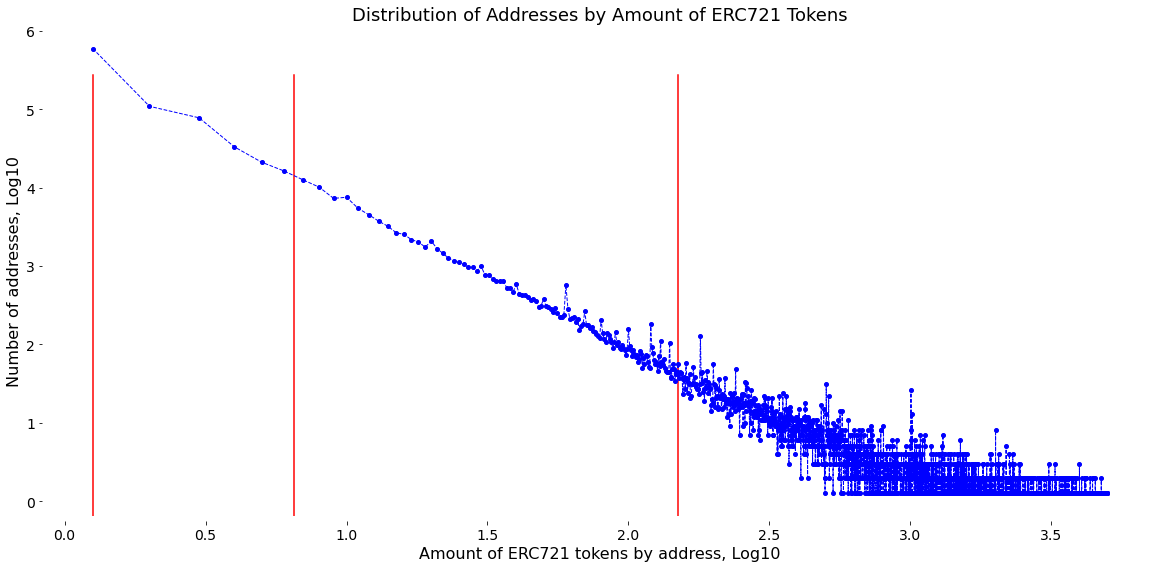

In [5]:
boundary_erc721_amount = \
    grade_boundaries_analysis(
        distribution_df=address_agg_by_sum_amount_of_tokens_df,
        value_column = 'sum_amount',
        value_chart_label = 'Amount of ERC721 tokens by address, Log10',
        value_name = 'Amount of ERC721 tokens',
        chart_title = 'Distribution of Addresses by Amount of ERC721 Tokens',
        max_show_value = 5000)

### Analysis of Grade Boundaries. Fee spending to contracts
Described in the [Extraordinary Hackers and Masters of the Great Web. Gas Analysis](gas__hackers_and_masters.ipynb)
Jupyter notebook

### Create Distribution Table for ERC721 Tokens

In [6]:
query_4 = f'''
    WITH erc721_amount AS (
        SELECT
            address,
            count(distinct token_address) as number_of_tokens,
            ARRAY_AGG(DISTINCT token_address) as token_list,
            sum(amount) as sum_amount
        FROM `{PROJECT_ID}.{ERC721_ANALYSIS_DATASET_NAME}.{ERC721_ROW_AMOUNT_TABLE_NAME}`
        WHERE amount > 0
          AND address != '0x0000000000000000000000000000000000000000'
          AND address != token_address
        GROUP BY address),
    urbit_owners AS (
        SELECT
            owner,
            count(point) as sum_amount
        FROM `cosmic-keep-223223.erc721_analysis.azimuth_points`
        GROUP BY owner)
    SELECT
        '{MASTERS_AUDIENCE}' as audience,
        CASE
            WHEN (SELECT COUNT(1) FROM UNNEST(token_list) el WHERE el IN {erc721_tokens_manual_grade_3_tuple_str}) > 0 THEN 'Owners of the Selected ERC721 tokens'
            WHEN (SELECT COUNT(1) FROM UNNEST(token_list) el WHERE el IN {erc721_tokens_manual_grade_2_tuple_str}) > 0 AND sum_amount <= {boundary_erc721_amount[2]} THEN 'Owners of the Selected ERC721 tokens'
            ELSE 'Owners of ERC721 tokens'
        END
        AS segment,
        address,
        CASE
            WHEN sum_amount > {boundary_erc721_amount[2]} OR (SELECT COUNT(1) FROM UNNEST(token_list) el WHERE el IN {erc721_tokens_manual_grade_3_tuple_str}) > 0 THEN 3
            WHEN sum_amount > {boundary_erc721_amount[1]} OR (SELECT COUNT(1) FROM UNNEST(token_list) el WHERE el IN {erc721_tokens_manual_grade_2_tuple_str}) > 0 THEN 2
            WHEN sum_amount > {boundary_erc721_amount[0]} THEN 1
            ELSE null
        END
        AS grade,
        sum_amount,
        number_of_tokens
    FROM erc721_amount
    WHERE number_of_tokens > {min_number_of_tokens}

    UNION ALL

    SELECT
        '{CYBERPUNKS_AUDIENCE}' as audience,
        'Owners of the Selected ERC721 tokens' as segment,
        address,
        3 AS grade,
        sum_amount,
        number_of_tokens
    FROM erc721_amount
    WHERE (SELECT COUNT(1) FROM UNNEST(token_list) el WHERE el IN {erc721_tokens_manual_cyberpunks_tuple_str}) > 0

    UNION ALL

    SELECT
        '{CYBERPUNKS_AUDIENCE}' as audience,
        'Urbit Owners' as segment,
        owner as address,
        3 AS grade,
        sum_amount,
        1 as number_of_tokens
    FROM urbit_owners
'''

if DROP_TABLES:
    drop_table(table_name=ERC721_ANALYSIS_DISTRIBUTION_TABLE_NAME,
               dataset_name=ERC721_ANALYSIS_DATASET_NAME)

if CREATE_TABLES:
    create_table(query=query_4,
                 table_name=ERC721_ANALYSIS_DISTRIBUTION_TABLE_NAME,
                 dataset_name=ERC721_ANALYSIS_DATASET_NAME)


Table erc721_analysis:erc721_analysis_distribution has been deleted.
Table erc721_analysis:erc721_analysis_distribution has been created and filled 970,564 rows.


### Create Distribution Table for Spending Fee Analysis
Distribution has been calculated in the [Extraordinary Hackers and Masters of the Great Web. Gas Analysis](gas__hackers_and_masters.ipynb) Jupyter notebook.

